## **without `Early stopping`**

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1944 | Train acc: 0.3477 | Test loss: 1.1005 | Test acc: 0.2604
Epoch: 10 | Train loss: 0.9674 | Train acc: 0.4805 | Test loss: 0.8888 | Test acc: 0.5265
Epoch: 20 | Train loss: 0.9092 | Train acc: 0.6367 | Test loss: 0.9363 | Test acc: 0.4962
Epoch: 30 | Train loss: 0.7802 | Train acc: 0.6602 | Test loss: 0.8416 | Test acc: 0.6174
Epoch: 40 | Train loss: 0.9903 | Train acc: 0.5312 | Test loss: 0.8540 | Test acc: 0.6259
Epoch: 50 | Train loss: 0.8706 | Train acc: 0.5195 | Test loss: 0.9096 | Test acc: 0.4659
Epoch: 60 | Train loss: 0.9730 | Train acc: 0.5586 | Test loss: 1.1475 | Test acc: 0.3939
Epoch: 70 | Train loss: 0.7558 | Train acc: 0.6992 | Test loss: 1.1048 | Test acc: 0.4252
Epoch: 80 | Train loss: 0.8145 | Train acc: 0.6406 | Test loss: 0.8373 | Test acc: 0.6600
Epoch: 90 | Train loss: 0.8016 | Train acc: 0.5547 | Test loss: 0.8910 | Test acc: 0.5076
Total training time for model_2: 125.598 seconds


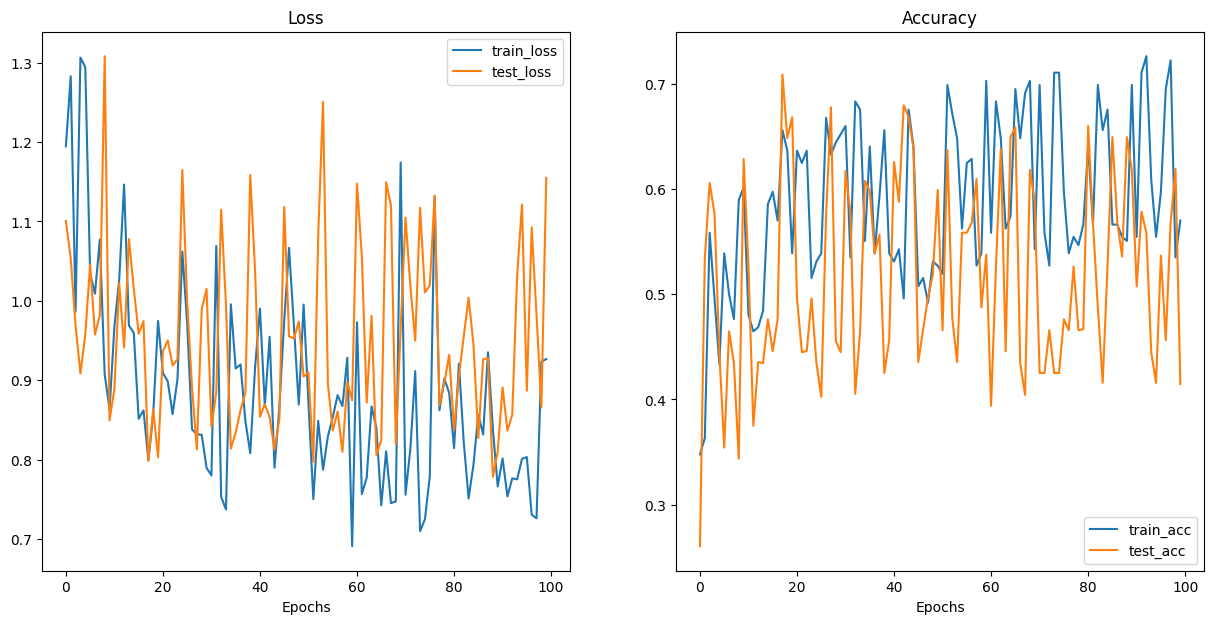

In [4]:
import os
import requests
import zipfile
from pathlib import Path
import matplotlib.pyplot as plt
from typing import Dict, List

import torch
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from timeit import default_timer as timer
from tqdm.auto import tqdm
from torch.cuda.amp import GradScaler, autocast

# Set the random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

# Set up the path
url = "https://github.com/mohd-faizy/PyTorch-Essentials/raw/main/_datasets/pizza_steak_sushi.zip"
image_path = Path("data/pizza_steak_sushi")
image_path.mkdir(parents=True, exist_ok=True)
zip_path = image_path.parent / "pizza_steak_sushi.zip"

# Step 2: Download the zip file containing the data
zip_path.write_bytes(requests.get(url).content)

# Step 3: Unzip the downloaded file into the image directory
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(image_path)


# Directories for training and testing data
train_dir = image_path / "train"
test_dir = image_path / "test"

# Data Transform with TrivialAugment and additional augmentations
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

# ImageFolder -> dataset
train_data_argumented = datasets.ImageFolder(root=train_dir,
                                             transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

# Dataset -> DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_augmented = DataLoader(dataset=train_data_argumented,
                                        batch_size=BATCH_SIZE,
                                        num_workers=NUM_WORKERS,
                                        shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

# Define the TinyVGG model class with batch normalization
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13, out_features=512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=512, out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return self.classifier(x)

# Create train_step function with mixed precision
def train_step(model: nn.Module,
               dataloader: DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device,
               scaler: GradScaler):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        with autocast():
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

# Create test_step function with mixed precision
def test_step(model: nn.Module, dataloader: DataLoader, loss_fn: nn.Module, device):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            with autocast():
                test_pred_logits = model(X)
                loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

# Define the train function with early stopping and mixed precision
def train(model: nn.Module, train_dataloader: DataLoader, test_dataloader: DataLoader, optimizer: torch.optim.Optimizer, loss_fn: nn.Module, epochs: int, device, scheduler=None):
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    best_val_loss = float('inf')
    early_stopping_patience = 10
    epochs_no_improve = 0
    scaler = GradScaler()

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, device=device, scaler=scaler)
        test_loss, test_acc = test_step(model=model, dataloader=test_dataloader, loss_fn=loss_fn, device=device)

        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

# Instantiate the model and send it to the target device
model = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_argumented.classes)).to(device)

# Setup Loss, Optimizer, and Learning Rate Scheduler
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# Train and evaluate the model
NUM_EPOCHS = 100
start_time = timer()
model_results = train(model=model,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)
end_time = timer()
print(f"Total training time for model_2: {end_time-start_time:.3f} seconds")


def loss_acc_plot_curves(results: Dict[str, List[float]]):
    # Get the loss and accuracy values of the results dictionary
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]
    train_acc = results["train_acc"]
    test_acc = results["test_acc"]

    # Epochs
    epochs = range(len(results["train_loss"]))

    # Plots
    plt.figure(figsize=(15, 7))

    # Loss
    plt.subplot(1, 2, 1) # Row->1, Col->2, idx->1
    plt.plot(epochs, train_loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2) # Row->1, Col->2, idx->2
    plt.plot(epochs, train_acc, label="train_acc")
    plt.plot(epochs, test_acc, label="test_acc")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();

loss_acc_plot_curves(model_results)

## **with `Early stopping`**

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1944 | Train acc: 0.3477 | Test loss: 1.1005 | Test acc: 0.2604
Epoch: 10 | Train loss: 0.9674 | Train acc: 0.4805 | Test loss: 0.8888 | Test acc: 0.5265
Epoch: 20 | Train loss: 0.8970 | Train acc: 0.5117 | Test loss: 0.8528 | Test acc: 0.6591
Early stopping
Total training time for model_2: 38.124 seconds


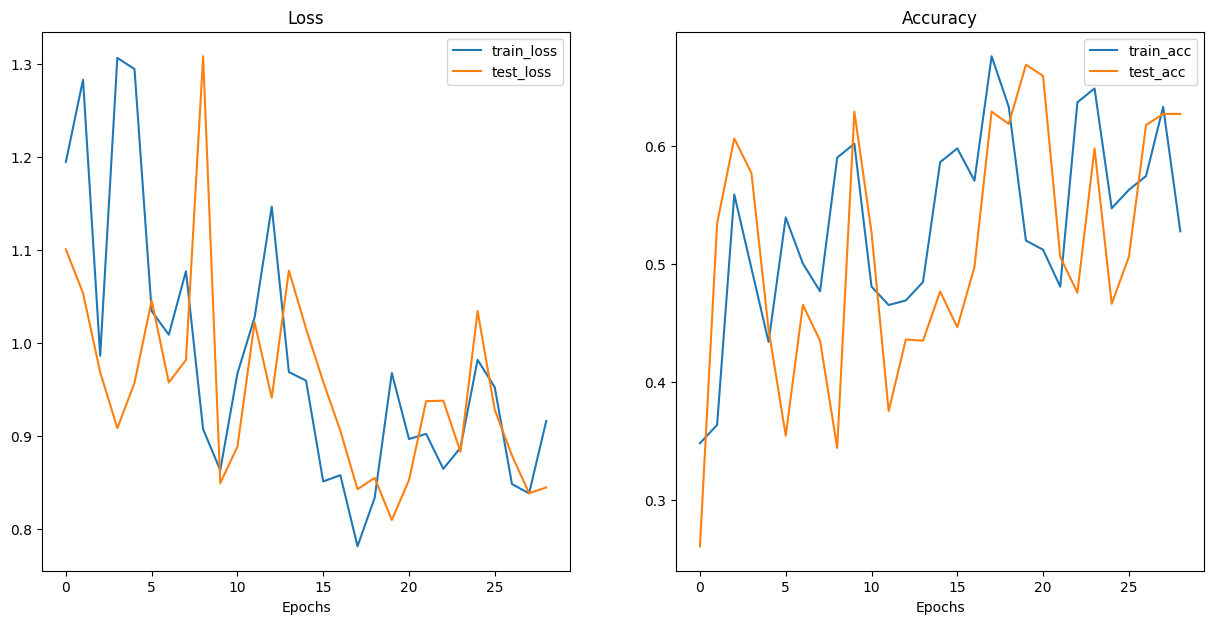

In [3]:
import os
import requests
import zipfile
from pathlib import Path
import matplotlib.pyplot as plt
from typing import Dict, List

import torch
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from timeit import default_timer as timer
from tqdm.auto import tqdm
from torch.cuda.amp import GradScaler, autocast

# Set the random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

# Set up the path
url = "https://github.com/mohd-faizy/PyTorch-Essentials/raw/main/_datasets/pizza_steak_sushi.zip"
image_path = Path("data/pizza_steak_sushi")
image_path.mkdir(parents=True, exist_ok=True)
zip_path = image_path.parent / "pizza_steak_sushi.zip"

# Step 2: Download the zip file containing the data
zip_path.write_bytes(requests.get(url).content)

# Step 3: Unzip the downloaded file into the image directory
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(image_path)


# Directories for training and testing data
train_dir = image_path / "train"
test_dir = image_path / "test"

# Data Transform with TrivialAugment and additional augmentations
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

# ImageFolder -> dataset
train_data_argumented = datasets.ImageFolder(root=train_dir,
                                             transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

# Dataset -> DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_augmented = DataLoader(dataset=train_data_argumented,
                                        batch_size=BATCH_SIZE,
                                        num_workers=NUM_WORKERS,
                                        shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

# Define the TinyVGG model class with batch normalization
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13, out_features=512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=512, out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return self.classifier(x)

# Create train_step function with mixed precision
def train_step(model: nn.Module,
               dataloader: DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device,
               scaler: GradScaler):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        with autocast():
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

# Create test_step function with mixed precision
def test_step(model: nn.Module, dataloader: DataLoader, loss_fn: nn.Module, device):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            with autocast():
                test_pred_logits = model(X)
                loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

# Define the train function with early stopping and mixed precision
def train(model: nn.Module, train_dataloader: DataLoader, test_dataloader: DataLoader, optimizer: torch.optim.Optimizer, loss_fn: nn.Module, epochs: int, device, scheduler=None):
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    best_val_loss = float('inf')
    early_stopping_patience = 10
    epochs_no_improve = 0
    scaler = GradScaler()

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, device=device, scaler=scaler)
        test_loss, test_acc = test_step(model=model, dataloader=test_dataloader, loss_fn=loss_fn, device=device)
        if scheduler:
            scheduler.step(test_loss)
        if test_loss < best_val_loss:
            best_val_loss = test_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print("Early stopping")
            break
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

# Instantiate the model and send it to the target device
model = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_argumented.classes)).to(device)

# Setup Loss, Optimizer, and Learning Rate Scheduler
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# Train and evaluate the model
NUM_EPOCHS = 100
start_time = timer()
model_results = train(model=model,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device,
                        scheduler=scheduler)
end_time = timer()
print(f"Total training time for model_2: {end_time-start_time:.3f} seconds")


def loss_acc_plot_curves(results: Dict[str, List[float]]):
    # Get the loss and accuracy values of the results dictionary
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]
    train_acc = results["train_acc"]
    test_acc = results["test_acc"]

    # Epochs
    epochs = range(len(results["train_loss"]))

    # Plots
    plt.figure(figsize=(15, 7))

    # Loss
    plt.subplot(1, 2, 1) # Row->1, Col->2, idx->1
    plt.plot(epochs, train_loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2) # Row->1, Col->2, idx->2
    plt.plot(epochs, train_acc, label="train_acc")
    plt.plot(epochs, test_acc, label="test_acc")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();

loss_acc_plot_curves(model_results)